In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, rand
import collections
import statsmodels.api as sm

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv("Sample_Washington.csv")
df

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,Historic Anacostia,Private room,55,2,74,2020-11-30,0.60,2,341,"Washington, D.C."
1,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Private room,99,2,31,2016-09-22,0.25,3,173,"Washington, D.C."
2,"Kalorama Heights, Adams Morgan, Lanier Heights",Entire home/apt,74,3,95,2020-03-05,0.69,2,177,"Washington, D.C."
3,"Kalorama Heights, Adams Morgan, Lanier Heights",Private room,42,2,112,2019-10-30,0.82,2,0,"Washington, D.C."
4,"Dupont Circle, Connecticut Avenue/K Street",Entire home/apt,185,2,154,2020-10-05,1.18,2,1,"Washington, D.C."
...,...,...,...,...,...,...,...,...,...,...
4065,"Cathedral Heights, McLean Gardens, Glover Park",Entire home/apt,89,1,3,2020-12-11,3.00,3,161,"Washington, D.C."
4066,"Cleveland Park, Woodley Park, Massachusetts Av...",Entire home/apt,89,1,3,2020-12-11,3.00,3,0,"Washington, D.C."
4067,"Cathedral Heights, McLean Gardens, Glover Park",Entire home/apt,89,2,3,2020-12-11,3.00,3,174,"Washington, D.C."
4068,"Cathedral Heights, McLean Gardens, Glover Park",Entire home/apt,100,2,1,2020-12-20,1.00,3,334,"Washington, D.C."


In [3]:
df = df.drop(columns=['neighbourhood'])
df = df.drop(columns=['city'])
df = df.drop(columns=['last_review'])

In [4]:
df.price=np.log(df.price)

In [13]:
df_apartament = df.loc[df.room_type == "Entire home/apt"]
df_apartament = df_apartament.drop(columns=['room_type'])

In [14]:
df_apartament.shape 

(2929, 6)

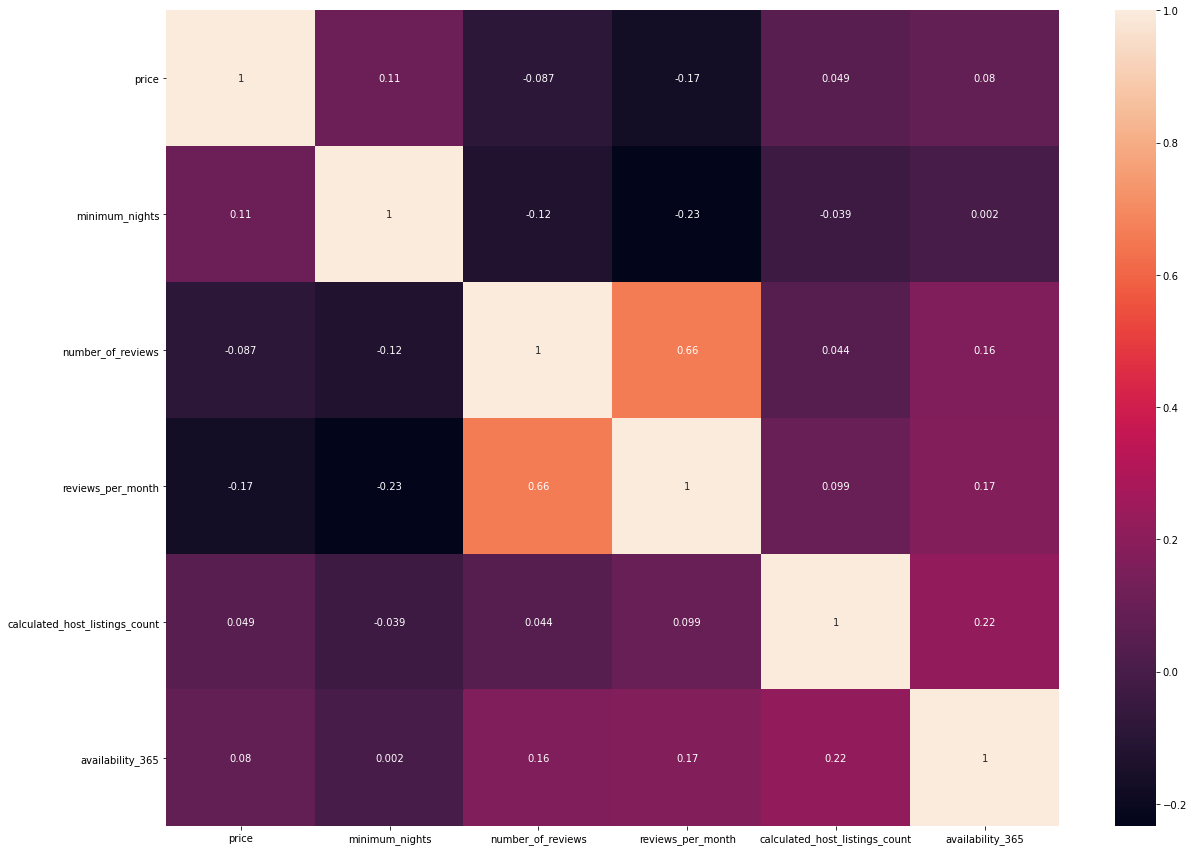

In [16]:
corrmat = df_apartament[df_apartament._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True)
plt.show()

In [17]:
#Apartament
train, test = train_test_split(df_apartament, test_size=0.2, random_state=0)
X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)
y_train = train.price
y_test = test.price

In [50]:
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    MSE = [mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train))), mean_squared_error(np.exp(y_test), np.exp(y_pred))]
    RMSE = [np.sqrt(mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train)))),np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'MSE': MSE, 'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

def visualising(X_train, X_test, y_train, y_test, y_pred, model):
    ### Training set ### 
    plt.scatter(X_train[['availability_365']], np.exp(y_train), color = 'red')
    plt.plot(X_train[['availability_365']], np.exp(model.predict(X_train)), 'bo')
    plt.title('Price vs Availability 365 (Training set) Washington D.C.')
    plt.xlabel('Availability 365')
    plt.ylabel('Price')
    plt.show()
    
    ### Test set ### 
    plt.scatter(X_test[['availability_365']], np.exp(y_test), color = 'red')
    plt.plot(X_test[['availability_365']], np.exp(y_pred), 'bo')
    plt.title('Price vs Availability 365 (Test set) Washington D.C.')
    plt.xlabel('Availability 365')
    plt.ylabel('Price')
    plt.show()


In [51]:
mr = LinearRegression().fit(X_train, y_train)
mr.coef_, mr.intercept_

(array([ 0.02399784,  0.00042283, -0.06842035,  0.01113526,  0.00037776]),
 4.748173576863305)

In [52]:
mr_y_pred = mr.predict(X_test)
metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,5189.85,72.04,0.05
Test,4756.44,68.97,0.04


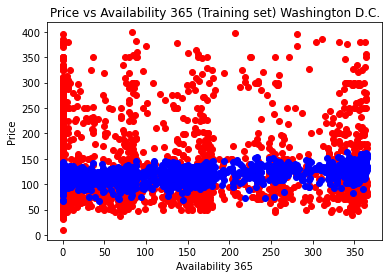

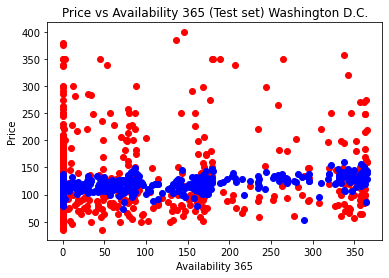

In [53]:
visualising(X_train, X_test, y_train, y_test, mr_y_pred, mr)

In [54]:
X = sm.add_constant(X_train)
mr1 = sm.OLS(y_train, X).fit()
#mr1.pvalues
mr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     25.99
Date:                Tue, 09 Feb 2021   Prob (F-statistic):           1.29e-25
Time:                        21:13:44   Log-Likelihood:                -1561.5
No. Observations:                2343   AIC:                             3135.
Df Residuals:                    2337   BIC:                             3170.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              4.7482      0.027    176.722      0.000       4.695       4.801
minimum_nights                     0.0240      0.008      3.174      0.002       0.009       0.039
number_of_reviews                  0.0004      0.000      1.583      0.113      -0.000       0.001
reviews_per_month                 -0.0684      0.009     -7.840      0.000      -0.086      -0.051
calculated_host_listings_count     0.0111      0.005      2.138      0.033       0.001       0.021
availability_365                   0.0004   7.98e-05      4.737      0.000       0.000       0.001
==============================================================================
Omnibus:                       37.560   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.640
Skew:                           0.304   Prob(JB):                     4.07e-09
Kurtosis:                       2.838   Cond. No.                         484.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
X_train_opt = X_train.drop(columns=["number_of_reviews"])
X_test_opt = X_test.drop(columns=["number_of_reviews"])
X_train_opt

,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365
2956,4,0.54,1,0
3926,4,0.97,1,48
1866,2,2.35,1,0
2261,3,0.03,4,0
947,3,0.45,1,0
...,...,...,...,...
1116,4,0.05,1,359
1217,3,0.50,2,0
2384,3,0.34,5,0
3678,1,2.86,1,239


In [74]:
mr = LinearRegression().fit(X_train_opt, y_train)
mr.coef_, mr.intercept_

(array([ 0.02452972, -0.05950874,  0.0108511 ,  0.00038515]), 4.7514562468356)

In [75]:
mr_y_pred = mr.predict(X_test_opt)
metrics(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,5193.44,72.07,0.05
Test,4756.85,68.97,0.04


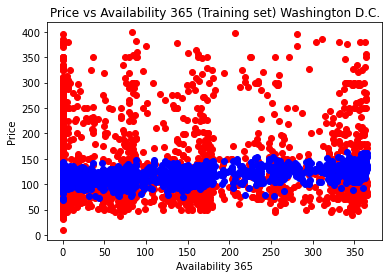

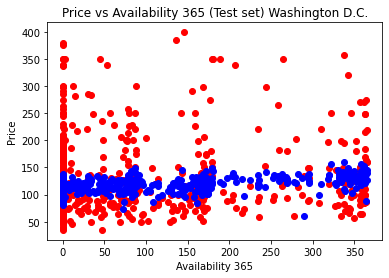

In [76]:
visualising(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr)

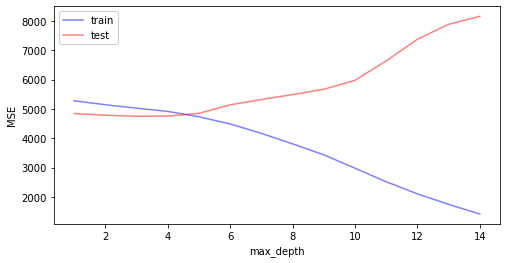

In [59]:
def max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeRegressor(max_depth = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [60]:
dt = DecisionTreeRegressor(max_depth = 4, random_state=10).fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
metrics(X_train, X_test, y_train, y_test, dt_y_pred, dt).round(2)

,MSE,RMSE,R2
Train,4916.89,70.12,0.11
Test,4757.56,68.98,0.02


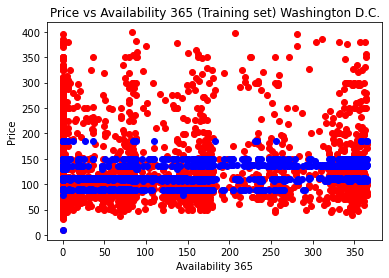

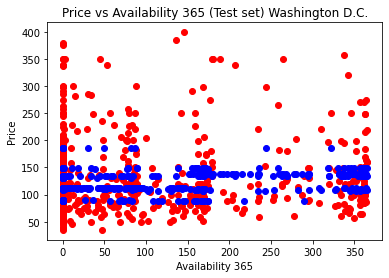

In [61]:
visualising(X_train, X_test, y_train, y_test, dt_y_pred, dt)

Text(0.5, 1.0, 'Decision Tree. Feature Importance. Washington D.C.')

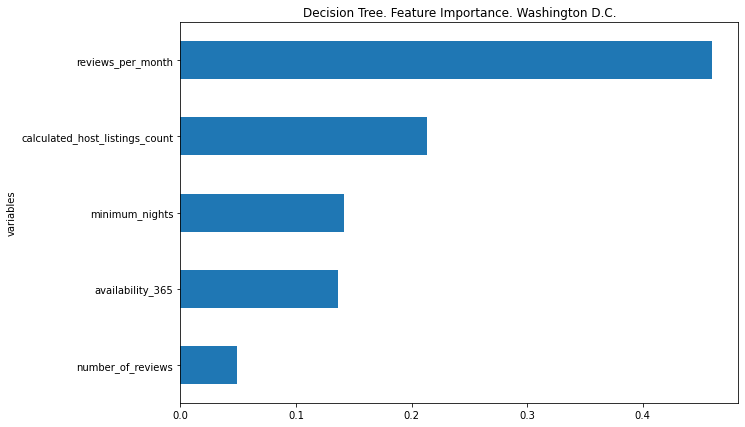

In [62]:
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'variables': X_train.columns})
dt_imp = dt_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
dt_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Decision Tree. Feature Importance. Washington D.C.')

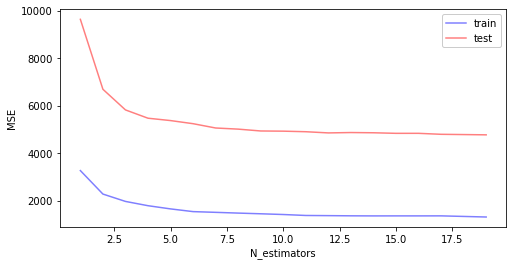

In [63]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
rf_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

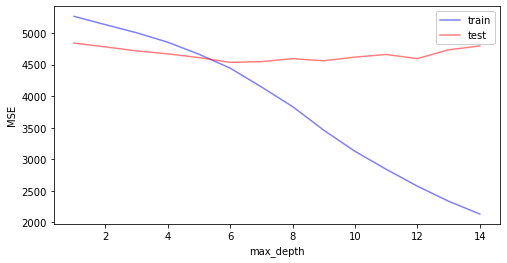

In [64]:
def rf_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=8, max_depth =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
rf_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [65]:
rf = RandomForestRegressor(n_estimators = 8, max_depth = 5, random_state = 10).fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
metrics(X_train, X_test, y_train, y_test, rf_y_pred, rf).round(2)

,MSE,RMSE,R2
Train,4667.29,68.32,0.17
Test,4613.33,67.92,0.05


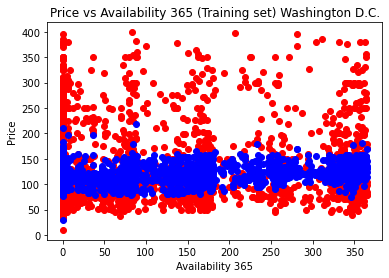

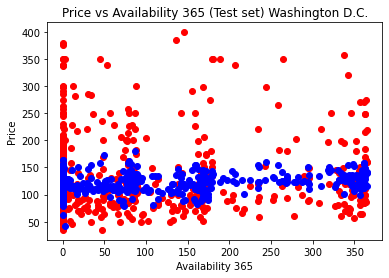

In [66]:
visualising(X_train, X_test, y_train, y_test, rf_y_pred, rf)

<AxesSubplot:ylabel='variables'>

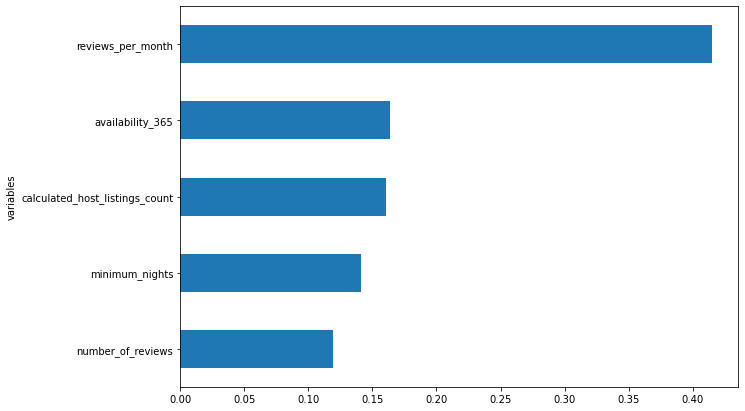

In [67]:
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'variables': X_train.columns})
rf_imp = rf_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
rf_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
#plt.title('Random Forest. Feature Importance. Washington D.C.')

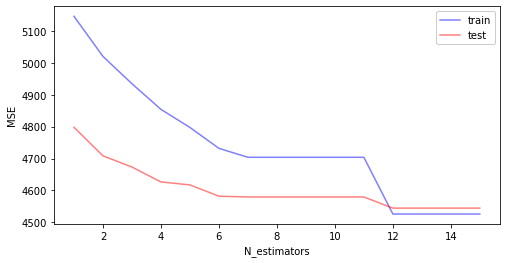

In [68]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
catboost_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,16)))

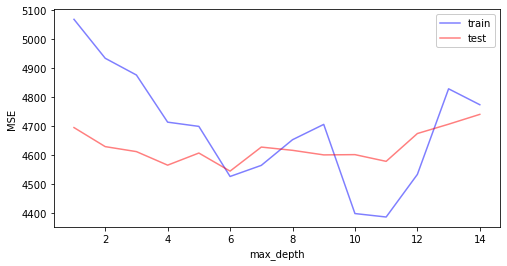

In [69]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=12, max_depth=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [70]:
catboost = CatBoostRegressor(iterations=12, max_depth=6, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
cat_y_pred = catboost.predict(X_test)
metrics(X_train, X_test, y_train, y_test, cat_y_pred, catboost).round(2)

,MSE,RMSE,R2
Train,4526.26,67.28,0.18
Test,4544.75,67.41,0.07


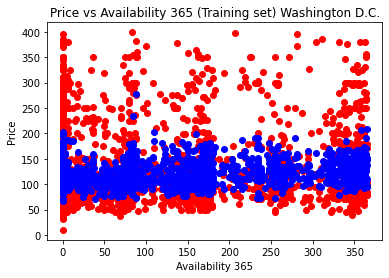

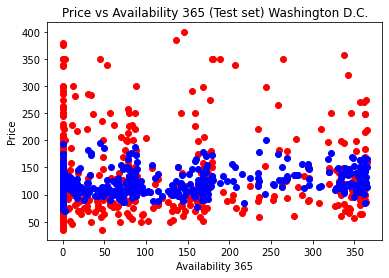

In [71]:
visualising(X_train, X_test, y_train, y_test, cat_y_pred, catboost)

Text(0.5, 1.0, 'Boosting. Feature Importance. Washington D.C.')

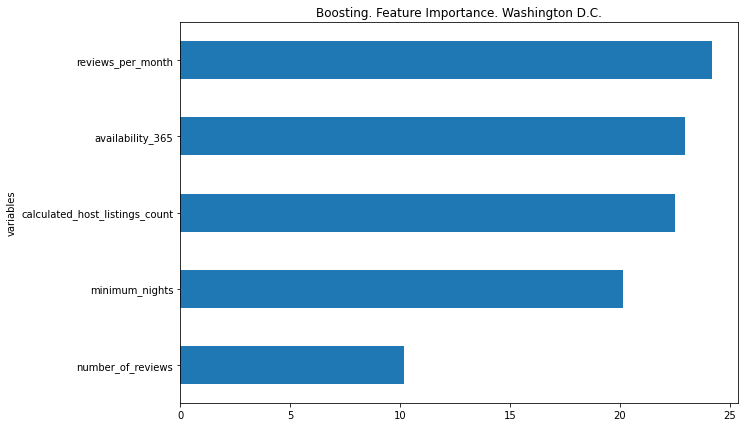

In [72]:
cb_imp = pd.DataFrame({'imp': catboost.get_feature_importance(), 'variables': X_train.columns})
cb_imp = cb_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
cb_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance. Washington D.C.')